In [1]:
# Data wrangling
import pandas as pd 

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

# Date wrangling
import datetime

# Math operations
import numpy as np

# Random sampling
import random

# mlp for multi-output regression
from numpy import mean
from numpy import std
from itertools import combinations_with_replacement

In [2]:
def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=-1) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Creating placeholder lists
    X, Y = [], []

    for i in range(len(ts) - lag - n_ahead):
        Y.append(ts[(i + lag), target_index])
        # X.append(ts[i:(i + lag)])

    ts = np.delete(ts, -1, axis=1)
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    if len(ts) - lag <= 0:
        X.append(np.concatenate(ts))
    else:
        for i in range(len(ts) - lag - n_ahead):
            X.append(np.concatenate(ts[i+1:(i + lag + 1)]))

    X = np.array(X)
    Y = np.array(Y)

    # Reshaping the X array to an RNN input shape 
    # X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

In [3]:
df2005 = pd.read_csv("../data/forModels/clean_data_2005.csv", sep = ',')
df2005.index = pd.to_datetime(df2005.Date, format="%d.%m.%Y")
df2005 = df2005.drop(['Date'], axis=1)

df2006 = pd.read_csv("../data/forModels/clean_data_2006.csv", sep = ',')
df2006.index = pd.to_datetime(df2006.Date, format="%d.%m.%Y")
df2006 = df2006.drop(['Date'], axis=1)

print(f'Shape of data 2005: {df2005.shape}')
print(f'Shape of data 2006: {df2006.shape}')

df = pd.concat([df2005, df2006], axis=0)


Shape of data 2005: (165, 5)
Shape of data 2006: (165, 5)


In [4]:
# Share of obs in testing 
test_share = 0.2

# The features used in the modeling 
# features_final = ['Avg', 'Dev', 'Rain', 'DD', 'DD Sum', 'CountTrap1', 'CountTrap2', 'CountTrap3', 'Sum']
features_final = ['Avg', 'DDSum', 'Rain', 'Sum_trap']

In [7]:
ts = df[features_final]

nrows = ts.shape[0]

# Spliting into train and test sets
train = ts[0:int(nrows * (1 - test_share))]
test = ts[int(nrows * (1 - test_share)):]

# Scaling the data 
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

# Creating the final scaled frame 
ts_s = pd.concat([train, test])
ts_s

,Avg,DDSum,Rain,Sum_trap
Date,,,,
2005-05-01,-0.624916,-1.342969,-0.303072,-0.728265
2005-05-02,-0.168788,-1.325268,-0.303072,-0.728265
2005-05-03,0.093380,-1.303316,0.178342,-0.728265
2005-05-04,-0.560973,-1.292061,0.675804,-0.728265
2005-05-05,-1.392236,-1.292061,3.387774,-0.728265
...,...,...,...,...
2006-10-08,-0.921187,2.550499,-0.303072,-0.728265
2006-10-09,-0.942501,2.555517,-0.303072,-0.728265
2006-10-10,-1.119411,2.557643,-0.303072,-0.728265


In [8]:
def normalize(X, axis=-1, order=2):
    """ Normalize the dataset X """
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

In [9]:
def polynomial_features(X, degree):
    n_samples, n_features = np.shape(X)

    def index_combinations():
        combs = [combinations_with_replacement(range(n_features), i) for i in range(0, degree + 1)]
        flat_combs = [item for sublist in combs for item in sublist]
        return flat_combs
    
    combinations = index_combinations()
    n_output_features = len(combinations)
    X_new = np.empty((n_samples, n_output_features))
    
    for i, index_combs in enumerate(combinations):  
        X_new[:, i] = np.prod(X[:, index_combs], axis=1)

    return X_new

In [10]:
def shuffle_data(X, y, seed=None):
    """ Random shuffle of the samples in X and y """
    if seed:
        np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    return X[idx], y[idx]

In [11]:
def k_fold_cross_validation_sets(X, y, k, shuffle=True):
    """ Split the data into k sets of training / test data """
    if shuffle:
        X, y = shuffle_data(X, y)

    n_samples = len(y)
    left_overs = {}
    n_left_overs = (n_samples % k)
    if n_left_overs != 0:
        left_overs["X"] = X[-n_left_overs:]
        left_overs["y"] = y[-n_left_overs:]
        X = X[:-n_left_overs]
        y = y[:-n_left_overs]

    X_split = np.split(X, k)
    y_split = np.split(y, k)
    sets = []
    for i in range(k):
        X_test, y_test = X_split[i], y_split[i]
        X_train = np.concatenate(X_split[:i] + X_split[i + 1:], axis=0)
        y_train = np.concatenate(y_split[:i] + y_split[i + 1:], axis=0)
        sets.append([X_train, X_test, y_train, y_test])

    # Add left over samples to last set as training samples
    if n_left_overs != 0:
        np.append(sets[-1][0], left_overs["X"], axis=0)
        np.append(sets[-1][2], left_overs["y"], axis=0)

    return np.array(sets)

In [12]:
def mean_squared_error(y_true, y_pred):
    """ Returns the mean squared error between y_true and y_pred """
    mse = np.mean(np.power(y_true - y_pred, 2))
    return mse

In [13]:
from __future__ import print_function, division
import numpy as np
import math


class l1_regularization():
    """ Regularization for Lasso Regression """
    def __init__(self, alpha):
        self.alpha = alpha
    
    def __call__(self, w):
        return self.alpha * np.linalg.norm(w)

    def grad(self, w):
        return self.alpha * np.sign(w)

class l2_regularization():
    """ Regularization for Ridge Regression """
    def __init__(self, alpha):
        self.alpha = alpha
    
    def __call__(self, w):
        return self.alpha * 0.5 *  w.T.dot(w)

    def grad(self, w):
        return self.alpha * w

class l1_l2_regularization():
    """ Regularization for Elastic Net Regression """
    def __init__(self, alpha, l1_ratio=0.5):
        self.alpha = alpha
        self.l1_ratio = l1_ratio

    def __call__(self, w):
        l1_contr = self.l1_ratio * np.linalg.norm(w)
        l2_contr = (1 - self.l1_ratio) * 0.5 * w.T.dot(w) 
        return self.alpha * (l1_contr + l2_contr)

    def grad(self, w):
        l1_contr = self.l1_ratio * np.sign(w)
        l2_contr = (1 - self.l1_ratio) * w
        return self.alpha * (l1_contr + l2_contr) 

class Regression(object):
    """ Base regression model. Models the relationship between a scalar dependent variable y and the independent 
    variables X. 
    Parameters:
    -----------
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, n_iterations, learning_rate):
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate

    def initialize_weights(self, n_features):
        """ Initialize weights randomly [-1/N, 1/N] """
        limit = 1 / math.sqrt(n_features)
        self.w = np.random.uniform(-limit, limit, (n_features, ))

    def fit(self, X, y):
        # Insert constant ones for bias weights
        X = np.insert(X, 0, 1, axis=1)
        self.training_errors = []
        self.initialize_weights(n_features=X.shape[1])

        # Do gradient descent for n_iterations
        for i in range(self.n_iterations):
            y_pred = X.dot(self.w)
            # Calculate l2 loss
            mse = np.mean(0.5 * (y - y_pred)**2 + self.regularization(self.w))
            self.training_errors.append(mse)
            # Gradient of l2 loss w.r.t w
            grad_w = -(y - y_pred).dot(X) + self.regularization.grad(self.w)
            # Update the weights
            self.w -= self.learning_rate * grad_w

    def predict(self, X):
        # Insert constant ones for bias weights
        X = np.insert(X, 0, 1, axis=1)
        y_pred = X.dot(self.w)
        return y_pred

class LinearRegression(Regression):
    """Linear model.
    Parameters:
    -----------
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    gradient_descent: boolean
        True or false depending if gradient descent should be used when training. If 
        false then we use batch optimization by least squares.
    """
    def __init__(self, n_iterations=100, learning_rate=0.001, gradient_descent=True):
        self.gradient_descent = gradient_descent
        # No regularization
        self.regularization = lambda x: 0
        self.regularization.grad = lambda x: 0
        super(LinearRegression, self).__init__(n_iterations=n_iterations,
                                            learning_rate=learning_rate)
    def fit(self, X, y):
        # If not gradient descent => Least squares approximation of w
        if not self.gradient_descent:
            # Insert constant ones for bias weights
            X = np.insert(X, 0, 1, axis=1)
            # Calculate weights by least squares (using Moore-Penrose pseudoinverse)
            U, S, V = np.linalg.svd(X.T.dot(X))
            S = np.diag(S)
            X_sq_reg_inv = V.dot(np.linalg.pinv(S)).dot(U.T)
            self.w = X_sq_reg_inv.dot(X.T).dot(y)
        else:
            super(LinearRegression, self).fit(X, y)

class LassoRegression(Regression):
    """Linear regression model with a regularization factor which does both variable selection 
    and regularization. Model that tries to balance the fit of the model with respect to the training 
    data and the complexity of the model. A large regularization factor with decreases the variance of 
    the model and do para.
    Parameters:
    -----------
    degree: int
        The degree of the polynomial that the independent variable X will be transformed to.
    reg_factor: float
        The factor that will determine the amount of regularization and feature
        shrinkage. 
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, degree, reg_factor, n_iterations=3000, learning_rate=0.01):
        self.degree = degree
        self.regularization = l1_regularization(alpha=reg_factor)
        super(LassoRegression, self).__init__(n_iterations, 
                                            learning_rate)

    def fit(self, X, y):
        X = normalize(polynomial_features(X, degree=self.degree))
        super(LassoRegression, self).fit(X, y)

    def predict(self, X):
        X = normalize(polynomial_features(X, degree=self.degree))
        return super(LassoRegression, self).predict(X)

class PolynomialRegression(Regression):
    """Performs a non-linear transformation of the data before fitting the model
    and doing predictions which allows for doing non-linear regression.
    Parameters:
    -----------
    degree: int
        The degree of the polynomial that the independent variable X will be transformed to.
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, degree, n_iterations=3000, learning_rate=0.001):
        self.degree = degree
        # No regularization
        self.regularization = lambda x: 0
        self.regularization.grad = lambda x: 0
        super(PolynomialRegression, self).__init__(n_iterations=n_iterations,
                                                learning_rate=learning_rate)

    def fit(self, X, y):
        X = polynomial_features(X, degree=self.degree)
        super(PolynomialRegression, self).fit(X, y)

    def predict(self, X):
        X = polynomial_features(X, degree=self.degree)
        return super(PolynomialRegression, self).predict(X)

class RidgeRegression(Regression):
    """Also referred to as Tikhonov regularization. Linear regression model with a regularization factor.
    Model that tries to balance the fit of the model with respect to the training data and the complexity
    of the model. A large regularization factor with decreases the variance of the model.
    Parameters:
    -----------
    reg_factor: float
        The factor that will determine the amount of regularization and feature
        shrinkage. 
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, reg_factor, n_iterations=1000, learning_rate=0.001):
        self.regularization = l2_regularization(alpha=reg_factor)
        super(RidgeRegression, self).__init__(n_iterations, 
                                            learning_rate)

class PolynomialRidgeRegression(Regression):
    """Similar to regular ridge regression except that the data is transformed to allow
    for polynomial regression.
    Parameters:
    -----------
    degree: int
        The degree of the polynomial that the independent variable X will be transformed to.
    reg_factor: float
        The factor that will determine the amount of regularization and feature
        shrinkage. 
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, degree, reg_factor, n_iterations=3000, learning_rate=0.01, gradient_descent=True):
        self.degree = degree
        self.regularization = l2_regularization(alpha=reg_factor)
        super(PolynomialRidgeRegression, self).__init__(n_iterations, 
                                                        learning_rate)

    def fit(self, X, y):
        X = normalize(polynomial_features(X, degree=self.degree))
        super(PolynomialRidgeRegression, self).fit(X, y)

    def predict(self, X):
        X = normalize(polynomial_features(X, degree=self.degree))
        return super(PolynomialRidgeRegression, self).predict(X)

class ElasticNet(Regression):
    """ Regression where a combination of l1 and l2 regularization are used. The
    ratio of their contributions are set with the 'l1_ratio' parameter.
    Parameters:
    -----------
    degree: int
        The degree of the polynomial that the independent variable X will be transformed to.
    reg_factor: float
        The factor that will determine the amount of regularization and feature
        shrinkage. 
    l1_ration: float
        Weighs the contribution of l1 and l2 regularization.
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, degree=1, reg_factor=0.05, l1_ratio=0.5, n_iterations=3000, 
                learning_rate=0.01):
        self.degree = degree
        self.regularization = l1_l2_regularization(alpha=reg_factor, l1_ratio=l1_ratio)
        super(ElasticNet, self).__init__(n_iterations, 
                                        learning_rate)

    def fit(self, X, y):
        X = normalize(polynomial_features(X, degree=self.degree))
        super(ElasticNet, self).fit(X, y)

    def predict(self, X):
        X = normalize(polynomial_features(X, degree=self.degree))
        return super(ElasticNet, self).predict(X)

In [14]:
lowest_error = float("inf")
best_reg_factor = None
print ("Finding regularization constant using cross validation:")
k = 8
poly_degree = 3
for reg_factor in np.arange(0, 0.1, 0.01):
    cross_validation_sets = k_fold_cross_validation_sets(
        X_train, y_train, k=k)
    mse = 0
    for _X_train, _X_test, _y_train, _y_test in cross_validation_sets:
        model = PolynomialRidgeRegression(degree=poly_degree, 
                                        reg_factor=reg_factor,
                                        learning_rate=0.001,
                                        n_iterations=500)
        model.fit(_X_train, _y_train)
        y_pred = model.predict(_X_test)
        _mse = mean_squared_error(_y_test, y_pred)
        mse += _mse
    mse /= k

    # Print the mean squared error
    print ("\tMean Squared Error: %s (regularization: %s)" % (mse, reg_factor))

    # Save reg. constant that gave lowest error
    if mse < lowest_error:
        best_reg_factor = reg_factor
        lowest_error = mse


Finding regularization constant using cross validation:


NameError: name 'X_train' is not defined

In [43]:
def prepare_data(features_final, test_share=0.2):
    df2005 = pd.read_csv("../data/forModels/clean_data_2005.csv", sep = ',')
    df2005.index = pd.to_datetime(df2005.Date, format="%d.%m.%Y")
    df2005 = df2005.drop(['Date'], axis=1)

    df2006 = pd.read_csv("../data/forModels/clean_data_2006.csv", sep = ',')
    df2006.index = pd.to_datetime(df2006.Date, format="%d.%m.%Y")
    df2006 = df2006.drop(['Date'], axis=1)

    df = pd.concat([df2005, df2006], axis=0)

    ts = df[features_final]

    nrows = ts.shape[0]

    # Spliting into train and test sets
    train = ts[0:int(nrows * (1 - test_share))]
    test = ts[int(nrows * (1 - test_share)):]

    # Scaling the data 
    train_mean = train.mean()
    train_std = train.std()

    train = (train - train_mean) / train_std
    test = (test - train_mean) / train_std

    # Creating the final scaled frame 
    ts_s = pd.concat([train, test])
    return ts_s

In [72]:
y_pred_all = {"ElasticNet": {}, "PolynomialRidgeRegression": {}}

In [75]:
lowest_error = float("inf")
best_reg_factor = None
k = 8
poly_degree = 3

y_test_all = {"ElasticNet": {}, "PolynomialRidgeRegression": {}} # TODO make it a dict
y_pred_all = {"ElasticNet": {}, "PolynomialRidgeRegression": {}}
mse_all = {"ElasticNet": {}, "PolynomialRidgeRegression": {}}
for lag in range(2, 20, 2):
    y_test_all["PolynomialRidgeRegression"][lag] = {}
    y_test_all["ElasticNet"][lag] = {}
    y_pred_all["PolynomialRidgeRegression"][lag] = {}
    y_pred_all["ElasticNet"][lag] = {}
    mse_all["PolynomialRidgeRegression"][lag] = {}
    mse_all["ElasticNet"][lag] = {}
    ts_s = prepare_data(features_final)
    X, y = create_X_Y(ts_s.values, lag=lag, n_ahead=5)
    X_train = X[int(0.2*len(X)):]
    y_train = y[int(0.2*len(X)):]
    X_test = X[:int(0.2*len(X))]
    y_test = y[:int(0.2*len(y))]
    # Make prediction
    for iterations in range(2000, 20000, 2000):
    # TODO petla po iteration do 20000 co 2000 i dodac elasticnet if mse nan break
        model = PolynomialRidgeRegression(degree=3, 
                                        reg_factor=0.01,
                                        learning_rate=0.001,
                                        n_iterations=iterations)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        y_test_all["PolynomialRidgeRegression"][lag][iterations] = y_test
        y_pred_all["PolynomialRidgeRegression"][lag][iterations] = y_pred
        mse_all["PolynomialRidgeRegression"][lag][iterations] = mse
        # y_test_all.append(y_test)
        # y_pred_all.append(y_pred)
        # mse_all.append(mse)
        # if np.isnan(mse):
        #     break
        model = ElasticNet(degree=3, 
                        reg_factor=0.01,
                        l1_ratio=0.7,
                        learning_rate=0.001,
                        n_iterations=iterations)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        y_test_all["ElasticNet"][lag][iterations] = y_test
        y_pred_all["ElasticNet"][lag][iterations] = y_pred
        mse_all["ElasticNet"][lag][iterations] = mse

        # y_pred = model.predict(X_train)
        # mse = mean_squared_error(y_train, y_pred)
        # y_test_all.append(y_train)
        # y_pred_all.append(y_pred)

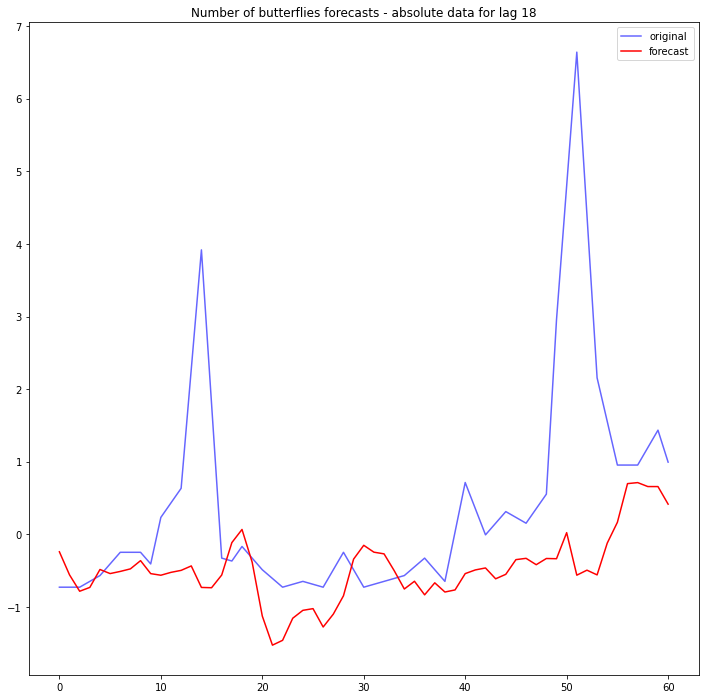

In [76]:
# for y_test, y_pred, lag in zip(y_test_all, y_pred_all, range(2, 20, 2)):
plt.figure(figsize=(12, 12))
plt.plot(range(len(y_pred_all["ElasticNet"][16][14000])), y_test_all["ElasticNet"][16][14000], color='blue', label='original', alpha=0.6)
plt.plot(range(len(y_pred_all["ElasticNet"][16][14000])), y_pred_all["ElasticNet"][16][14000], color='red', label='forecast')
plt.title(f'Number of butterflies forecasts - absolute data for lag {lag}')
plt.legend()
plt.show()

In [84]:
# dumping training results (training took 40 minutes)
import pickle

with open("y_test_all.pkl", "wb") as f:
    pickle.dump(y_test_all, f)
with open("y_pred_all.pkl", "wb") as f:
    pickle.dump(y_pred_all, f)
with open("mse_all.pkl", "wb") as f:
    pickle.dump(mse_all, f)


In [ ]:
# reading training results (training took 40 minutes)
with open("y_test_all.pkl", "rb") as f:
    y_test_all_read = pickle.load(f)
with open("y_pred_all.pkl", "rb") as f:
    y_pred_all_read = pickle.load(f)
with open("mse_all.pkl", "rb") as f:
    mse_all_read = pickle.load(f)

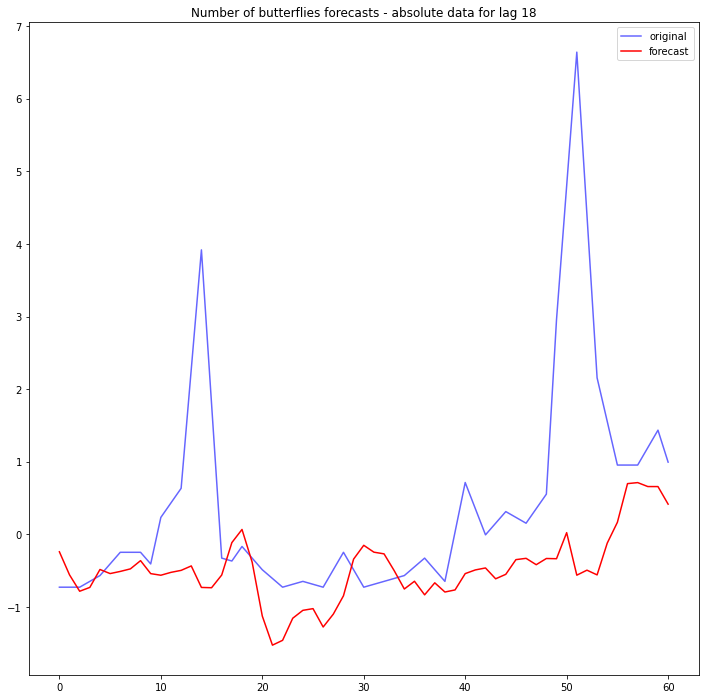

In [86]:
# for y_test, y_pred, lag in zip(y_test_all, y_pred_all, range(2, 20, 2)):
# results["model_name"][lag][n_iterations]
plt.figure(figsize=(12, 12))
plt.plot(range(len(y_pred_all_read["ElasticNet"][16][14000])), y_test_all_read["ElasticNet"][16][14000], color='blue', label='original', alpha=0.6)
plt.plot(range(len(y_pred_all_read["ElasticNet"][16][14000])), y_pred_all_read["ElasticNet"][16][14000], color='red', label='forecast')
plt.title(f'Number of butterflies forecasts - absolute data for lag {lag}')
plt.legend()
plt.show()

## TESTY MODELU

In [15]:
# Number of lags to use for models
lag = 2
# Steps ahead to forecast 
n_ahead = 5

X, y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead)
X_train = X[int(0.2*len(X)):]
y_train = y[int(0.2*len(X)):]
X_test = X[:int(0.2*len(X))]
y_test = y[:int(0.2*len(y))]


In [20]:
# Make final prediction
model = PolynomialRidgeRegression(degree=3, 
                                reg_factor=0.01,
                                learning_rate=0.001,
                                n_iterations=2000)
model.fit(X_train, y_train)

In [21]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print ("MSE: " + str(mse))

MSE: 0.6691855903979547


In [24]:
model = ElasticNet(degree=3, 
                        reg_factor=0.01,
                        l1_ratio=0.7,
                        learning_rate=0.001,
                        n_iterations=50000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print ("MSE: " + str(mse))

MSE: 0.9895307307284941


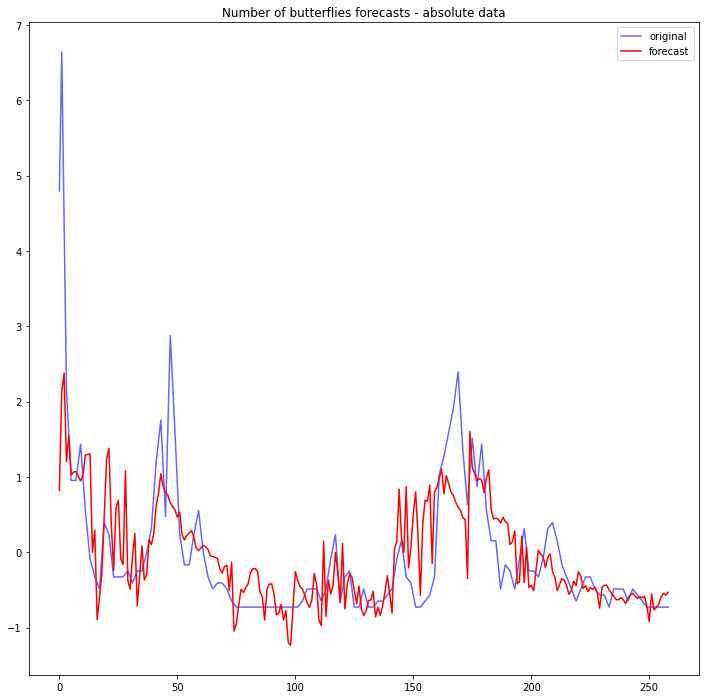

In [25]:
yhat = model.predict(X_train)
plt.figure(figsize=(12, 12))
plt.plot(range(len(yhat)), y_train, color='blue', label='original', alpha=0.6)
plt.plot(range(len(yhat)), yhat, color='red', label='forecast')
plt.title('Number of butterflies forecasts - absolute data')
plt.legend()
plt.show()

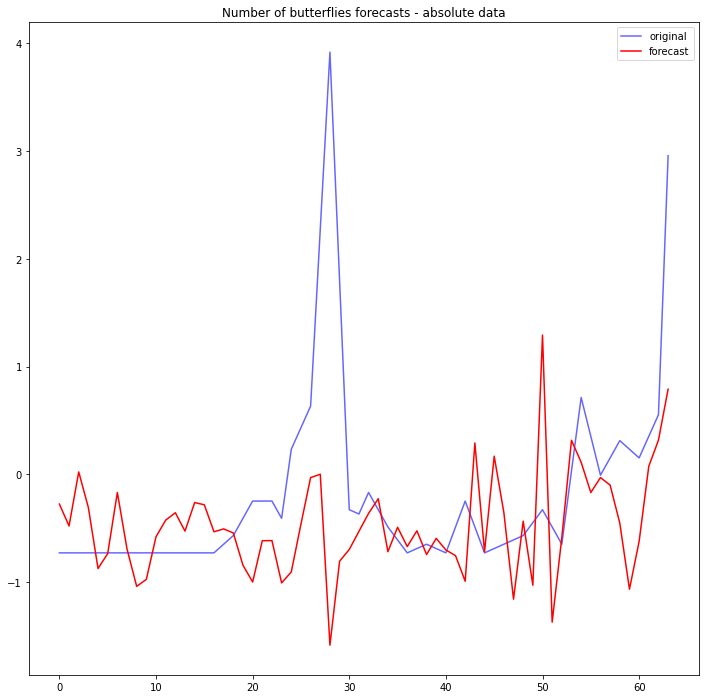

In [26]:
plt.figure(figsize=(12, 12))
plt.plot(range(len(y_pred)), y_test, color='blue', label='original', alpha=0.6)
plt.plot(range(len(y_pred)), y_pred, color='red', label='forecast')
plt.title('Number of butterflies forecasts - absolute data')
plt.legend()
plt.show()